In [1]:
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.stats as ss
import pandas as pd 
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import t

---
## Data set 
The Child Health and Development Studies investigate a range of topics. One study considered all pregnancies between 1960 and 1967 among women in the Kaiser Foundation Health Plan in the San Francisco East Bay area.

The data frame contains the following data, where each row represents a baby:

- bwt: birth weight (ounces)
- gestation: length of pregnancy (days)
- parity: 0 if mom's first baby, 1 if not mom's first baby
- age: mom's age (years)
- height: mom's height (inches)
- weight: mom's weight (pounds)
- smoke: 0 if mom is nonsmoker, 1 if mom is smoker



In [2]:
df = pd.read_csv('babies.csv').drop('case',axis='columns').dropna()
df.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284.0,0,27.0,62.0,100.0,0.0
1,113,282.0,0,33.0,64.0,135.0,0.0
2,128,279.0,0,28.0,64.0,115.0,1.0
4,108,282.0,0,23.0,67.0,125.0,1.0
5,136,286.0,0,25.0,62.0,93.0,0.0



## Prediction

This task will focus on building predictive models for birth weight based on the available data.

---
### Visualizing the Outcome

Produce a plot that visualizes the marginal distribution of birth weight.

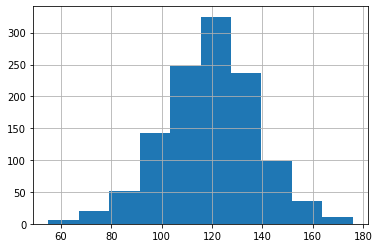

In [3]:
df.bwt.hist()

---
### Loss Functions

Define two loss functions, one that measures the absolute difference between observations and predictions, and one that gives "0" if the absolute difference is less than or equal to a threshold `thresh`, and "1" otherwise. (Essentially, the mean of this loss counts the proportion of predictions that within `thresh` distance of the observations.)

*Return the mean and the standard deviation of the losses.* 

In [4]:
def abs_diff_loss(obs, pred):
    
    resids = abs(pred-obs)
    return resids.mean(), resids.std(ddof=1)
    
def threshold_loss(obs, pred, thresh):
    
    resids = abs(obs-pred)>thresh
    resids = resids.astype(int)
    return resids.mean(), resids.std(ddof=1)
    

results = threshold_loss(np.arange(1,6), np.arange(5,0, -1), 2)
print(results)
    

(0.4, 0.5477225575051662)


Suppose you are using the absolute loss to measure performance of a model for predicting birth weight using the data we have provided.. If you wanted to set a test set aside for evaluation, how much data should you allocate for testing if you want to evaluate the performance of our predictor to within +/- 4 units of loss with 95% confidence? Provide code that computes the amount of data.

In [5]:
pred = df.bwt.median()
mu, sigma = abs_diff_loss(pred, df.bwt)
n_abs_loss = np.ceil((2*sigma/4)**2)

print(n_abs_loss)

34.0


Suppose you are using the threshold loss with a cutoff of 4 to measure performance of a model for predicting birth weight using the data we have provided. If you wanted to set a test set aside for evaluation, how much data should you allocate for testing if you want to evaluate the performance of our predictor to within +/- 0.05 of the actual generalization performance with 95% confidence? Provide code that computes the amount of data.

In [6]:
max_sigma = 0.5
n_thresh = np.ceil((2*max_sigma/0.05)**2)
print(n_thresh)

400.0


The standard deviation of a binary random variale is $\sqrt{p(1-p)}$ , where  𝑝  is the fraction of observations equal to 1. The largest this can be is 0.5. 

### Test Split

Set aside some amount of data for testing, and retain the rest for training.

In [7]:
X = df.drop('bwt', axis = 'columns').values
y = df.bwt.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                y, 
                                                test_size = int(n_abs_loss),
                                                random_state = 19920908)

## Simple Linear Model

Using Ordinary Least Squares, build a model to predict birth weight as a linear function of the other variables in the data.

In [8]:
simple_model = Pipeline([
    ('linear_regression', LinearRegression())])

### More Complex Model

Again using Ordinary Least Squares, develop second a model that has lower training error than the simple model.

In [9]:
complex_model = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias = False)),
    ('linear_regression', LinearRegression())
])

## Model Selection

Use cross-validation to compare the two model spaces to select the one you think will result in the smallest generalization error for one of the loss functions you defined above.

In [10]:
simple_cv = cross_val_score(simple_model, 
                            Xtrain, 
                            ytrain, 
                            cv = 5, 
                            scoring=make_scorer(mean_absolute_error))


print('Simple model cv:', simple_cv.mean())

complex_cv = cross_val_score(complex_model, 
                            Xtrain, 
                            ytrain, 
                            cv = 5, 
                            scoring=make_scorer(mean_absolute_error))

print('Complex Model:', complex_cv.mean())

Simple model cv: 12.366245052688436
Complex Model: 12.383314800178875


### Evaluation, Absolute Value, Normal approximation confidence interval

Provide a point estimate for the generalization error of your chosen model using the absolute difference loss. Also provide a 95% confidence interval for the true generalization error under this loss. Construct the interval using a normal approximation.

In [11]:
complex_model.fit(Xtrain, ytrain)
preds = complex_model.predict(Xtest)
mu, sigma = abs_diff_loss(ytest, preds)

tcrit = t.ppf(0.975, df=n_abs_loss-1)
radius = tcrit*sigma/np.sqrt(n_abs_loss)

np.arange(-1,2)*radius + mu

array([10.97604887, 14.57197765, 18.16790642])

### Evaluation, Threshold, Bootstrap approximation confidence interval

Provide a point estimate for the generalization error of your model using the threshold loss with a threshold of 4. Also provide a 95% confidence interval for the true generalization error under this loss. Construct the interval using the bootstrap.

In [13]:
numits = 10000
thresh = 4
bootstrap_loss=np.zeros(numits)
complex_model.fit(Xtrain, ytrain)


for i in range(numits):
    ix = np.random.randint(low=0, high = int(n_abs_loss), size = int(n_abs_loss))

    xboot = Xtest[ix]
    yboot = ytest[ix]
    ypreds = complex_model.predict(xboot)
    mu, sigma = threshold_loss(yboot, ypreds, thresh)
    bootstrap_loss[i]=mu
    
interval_estimate = np.quantile(bootstrap_loss, [0.025, 0.5, 0.975])

print(interval_estimate)


[0.67647059 0.82352941 0.94117647]


## Inference

### Association between Smoking and Birth Weight 

Conduct a statistical analysis that shows whether the data provide substantial evidence that smoking is associated with a difference in average birth weight if we ignore all other variables.

In [14]:
ols('bwt~smoke', data = df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bwt   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     76.02
Date:                Wed, 14 Oct 2020   Prob (F-statistic):           9.46e-18
Time:                        19:05:13   Log-Likelihood:                -5043.0
No. Observations:                1174   AIC:                         1.009e+04
Df Residuals:                    1172   BIC:                         1.010e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    123.0853      0.665    185.221      0.000     121.782     124.389
smoke         -9.2661      1.063     -8.719      0.000     -11.351      -7.181
==============================================================================
Omnibus:                       12.420   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.215
Skew:                          -0.103   Prob(JB):                     0.000183
Kurtosis:                       3.557   Cond. No.                         2.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Null hypohtesis is no association. We reject the null hypothesis at the 5% alpha level. From the data we have obtained, there seems to be an association between smoking and birthweight.

### Causality between Smoking and Birth Weight (X / 10pt)

Does this analysis prove that smoking causes reduced birth weight? 

No. Analysis does not account for potential confounders.

### Association between Smoking and Birth Weight (X / 10pt)

Conduct a statistical analysis that shows whether the data provide substantial evidence that smoking is associated with a change birth weight if we account for the other measured variables using a linear model.

In [15]:
var = ' + '.join([j for j in df.columns if j!= 'bwt'])
ols(formula='bwt~'+var, data = df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bwt   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     67.61
Date:                Wed, 14 Oct 2020   Prob (F-statistic):           2.87e-72
Time:                        19:06:32   Log-Likelihood:                -4904.7
No. Observations:                1174   AIC:                             9823.
Df Residuals:                    1167   BIC:                             9859.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -80.4109     14.347     -5.605      0.000    -108.559     -52.263
gestation      0.4440      0.029     15.258      0.000       0.387       0.501
parity        -3.3272      1.129     -2.947      0.003      -5.542      -1.112
age           -0.0090      0.086     -0.104      0.917      -0.177       0.159
height         1.1540      0.205      5.629      0.000       0.752       1.556
weight         0.0502      0.025      1.987      0.047       0.001       0.100
smoke         -8.4007      0.954     -8.807      0.000     -10.272      -6.529
==============================================================================
Omnibus:                        6.574   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                8.427
Skew:                           0.029   Prob(JB):                       0.0148
Kurtosis:                       3.411   Cond. No.                     9.80e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Null hypohtesis is no association.  We reject the null hypothesis at the 5% alpha level.  From the data we have obtained, there seems to be an association between smoking and birthweight.

### Causality between Smoking and Birth Weight (X / 10pt)

Does this analysis prove that smoking causes reduced birth weight?

No. There may be unknown confounders